# Load Images into Memory
This notebook is a duplicate of 4-Class-CNN, but will load images into memory instead of reading from disk. The end goal is to speed up training. I believe that reading from the disk is much slower than having the images in RAM.

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pdb

train_path = '..//data//helen//train_rotated//'
test_path = '..//data//helen//test_rotated//'
num_classes = 4

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import callbacks
from tensorflow.keras.models  import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
# from tensorflow.keras.optimizers import Adam, SGD, RMSprop

### Test interpolation algorithms

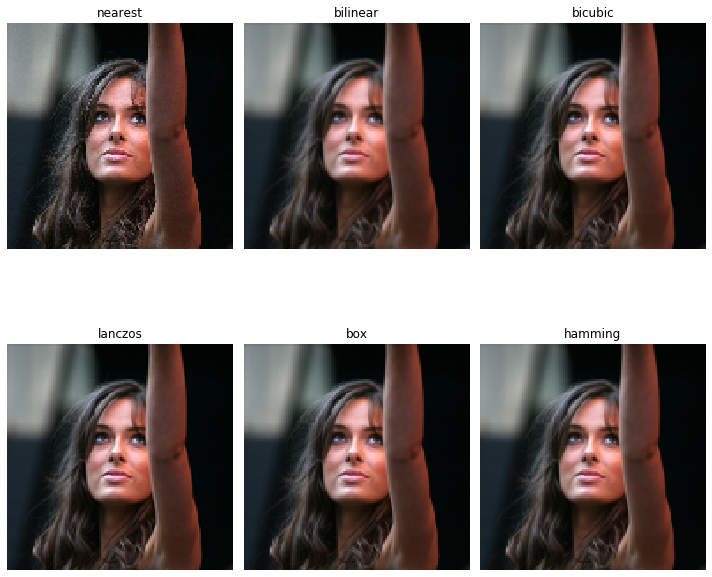

In [4]:
train_list = os.listdir(train_path+'0//')
img1 = image.load_img(train_path+'0//'+train_list[0], target_size=(128,128), interpolation='nearest')
img2 = image.load_img(train_path+'0//'+train_list[0], target_size=(128,128), interpolation='bilinear')
img3 = image.load_img(train_path+'0//'+train_list[0], target_size=(128,128), interpolation='bicubic')
img4 = image.load_img(train_path+'0//'+train_list[0], target_size=(128,128), interpolation='lanczos')
img5 = image.load_img(train_path+'0//'+train_list[0], target_size=(128,128), interpolation='box')
img6 = image.load_img(train_path+'0//'+train_list[0], target_size=(128,128), interpolation='hamming')
figures = {'nearest': img1, 
          'bilinear': img2,
          'bicubic': img3,
          'lanczos': img4,
          'box': img5,
          'hamming': img6}

def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
plot_figures(figures, 2, 3)

Most of those look the same... lets just use `bilinear`

### Which object size is smaller

In [23]:
img = image.load_img(train_path+'0//'+train_list[0])

import sys
print(sys.getsizeof(img), type(img))
img_arr = image.img_to_array(img)
print(sys.getsizeof(img_arr), type(img_arr))

56 <class 'PIL.JpegImagePlugin.JpegImageFile'>
29551280 <class 'numpy.ndarray'>


For some reason, the PIL Image is much smaller than the numpy representation, so we will try to load the PIL images into memory for training.

## Load in all images
I hope we have enough memory

### Load in as PIL Images
I'm going to load in the images from disk into memory as PIL Images, then see if keras can use those

In [24]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 34s 0us/step


In [26]:
print(type(x_train))
x_train.shape

<class 'numpy.ndarray'>


(50000, 32, 32, 3)

In [28]:
x_train = []
y_train = []
for c in [1,2,3,4]:
    train_list = os.listdir(train_path+str(c)+'//')
    for i in train_list:
        x_train.append(image.load_img(train_path+str(c)+'//'+train_list[0], target_size=(128,128), interpolation='bilinear'))
        y_train.append(c)

AttributeError: 'list' object has no attribute 'shape'

In [29]:
print(len(x_train))
print(len(y_train))

8000
8000


In [32]:
model_1.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
history = model_1.fit(x=x_train, y=y_train, batch_size=128, epochs=50, verbose=1, callbacks=my_callbacks)

AttributeError: 'Image' object has no attribute 'shape'

### PIL Image did not work. Lets try numpy arrays
These two cells will load in the images from disk to memory

#### Create the numpy arrays

In [229]:
import numpy as np

x_train = np.zeros(shape=(8000, 128, 128, 3), dtype=np.uint8)
y_train = np.zeros(shape=(8000), dtype=np.uint8)
for c in [0,1,2,3]:
    print(c)
    train_list = os.listdir(train_path+str(c)+'//')
    for i in range(len(train_list)):
        x_train[i + (c*2000)] = image.img_to_array(image.load_img(train_path+str(c)+'//'+train_list[i], target_size=(128,128), interpolation='bilinear'))
        y_train[i + (c*2000)] = c
print(x_train.shape)
print(y_train.shape)

0
1
2
3
(8000, 128, 128, 3)
(8000,)


In [230]:
x_test = np.zeros(shape=(330*4, 128, 128, 3), dtype=np.uint8)
y_test = np.zeros(shape=(330*4), dtype=np.uint8)
for c in [0,1,2,3]:
    print(c)
    test_list = os.listdir(test_path+str(c)+'//')
    for i in range(len(test_list)):
        x_test[i + (c*330)] = image.img_to_array(image.load_img(test_path+str(c)+'//'+test_list[i], target_size=(128,128), interpolation='bilinear'))
        y_test[i + (c*330)] = c

print(x_test.shape)
print(y_test.shape)

0
1
2
3
(1320, 128, 128, 3)
(1320,)


In [231]:
np.unique(y_train)

array([0, 1, 2, 3], dtype=uint8)

##### Make sure everything is correct:

0


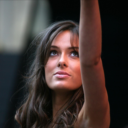

In [260]:
print(y_train[0])
Image.fromarray(x_train[0])

0


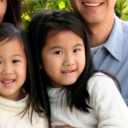

In [234]:
print(y_test[0])
Image.fromarray(x_test[0])

In [261]:
print(np.unique(y_train))
print(np.unique(y_test))

[0 1 2 3]
[0 1 2 3]


#### Save the numpy arrays

In [262]:
np.save(train_path+'x_train_rotated_bilinear', x_train)
np.save(train_path+'y_train_rotated_bilinear', y_train)

np.save(test_path+'x_test_rotated_bilinear', x_test)
np.save(test_path+'y_test_rotated_bilinear', y_test)

#### Load the numpy arrays

In [2]:
x_train = np.load(train_path+'x_train_rotated_bilinear.npy')
y_train = np.load(train_path+'y_train_rotated_bilinear.npy')
x_test = np.load(test_path+'x_test_rotated_bilinear.npy')
y_test = np.load(test_path+'y_test_rotated_bilinear.npy')

# Train a Model (no scaling, bilinear)
We will use the same model architecture as the previous notebook, 4-Class-CNN. We just want to make sure everything is working as expected and test the speed improvements from using images in RAM

#### Define Train function

In [264]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=200, initial_epoch=0, batch_size=128):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator().flow(x_train, y_train, batch_size=batch_size)

    validation_generator = ImageDataGenerator().flow(x_test, y_test, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)

    return history, model

#### Define Model

In [265]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(4),   # number of classes is 4
    Activation('softmax')
])

#### Execute Training

In [266]:
history, model = train(model_1)

Epoch 1/200
63/63 [==============================] - 9s 148ms/step - loss: 2.2657 - acc: 0.2511 - val_loss: 1.4914 - val_acc: 0.2379
Epoch 2/200
63/63 [==============================] - 5s 74ms/step - loss: 2.1001 - acc: 0.2550 - val_loss: 1.4698 - val_acc: 0.2545
Epoch 3/200
63/63 [==============================] - 5s 75ms/step - loss: 2.0660 - acc: 0.2604 - val_loss: 1.4778 - val_acc: 0.2682
Epoch 4/200
63/63 [==============================] - 5s 76ms/step - loss: 2.0499 - acc: 0.2531 - val_loss: 1.4873 - val_acc: 0.2712
Epoch 5/200
63/63 [==============================] - 5s 75ms/step - loss: 2.0143 - acc: 0.2614 - val_loss: 1.4948 - val_acc: 0.2803
Epoch 6/200
63/63 [==============================] - 5s 75ms/step - loss: 2.0173 - acc: 0.2626 - val_loss: 1.4959 - val_acc: 0.2864
Epoch 7/200
63/63 [==============================] - 5s 75ms/step - loss: 2.0002 - acc: 0.2657 - val_loss: 1.4948 - val_acc: 0.2909
Epoch 8/200
63/63 [==============================] - 5s 74ms/step - loss: 2

ITS TRAINING SO MUCH FASTER 😍

# Test Different Scaling Techniques
The best scaling was Standardization

## Normalize the data
People say that [normalizing image data](https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/) is important. Here we will normalize the data (0-1) and train.

0.4189 val_acc after 83 epochs

#### Verify that it works

In [271]:
train_generator = ImageDataGenerator(rescale=1.0/255.0).flow(x_train, y_train, seed=11, batch_size=1)
batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(1, 128, 128, 3), min=0.016, max=0.784


#### Define Train function

In [267]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(rescale=1.0/255.0).flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(rescale=1.0/255.0).flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)

    return history, model

#### Define Model

In [268]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(4),   # number of classes is 4
    Activation('softmax')
])

#### Execute Training

In [269]:
history, model = train(model_1)

Epoch 1/100
63/63 [==============================] - 11s 180ms/step - loss: 2.2424 - acc: 0.2481 - val_loss: 1.3932 - val_acc: 0.2500
Epoch 2/100
63/63 [==============================] - 4s 71ms/step - loss: 2.1195 - acc: 0.2384 - val_loss: 1.3943 - val_acc: 0.2470
Epoch 3/100
63/63 [==============================] - 4s 71ms/step - loss: 2.1019 - acc: 0.2401 - val_loss: 1.3979 - val_acc: 0.2523
Epoch 4/100
63/63 [==============================] - 4s 71ms/step - loss: 2.0887 - acc: 0.2420 - val_loss: 1.4060 - val_acc: 0.2561-
Epoch 5/100
63/63 [==============================] - 4s 71ms/step - loss: 2.0578 - acc: 0.2477 - val_loss: 1.4220 - val_acc: 0.2523
Epoch 6/100
63/63 [==============================] - 4s 70ms/step - loss: 2.0738 - acc: 0.2386 - val_loss: 1.4415 - val_acc: 0.2508
Epoch 7/100
63/63 [==============================] - 4s 71ms/step - loss: 2.0379 - acc: 0.2546 - val_loss: 1.4585 - val_acc: 0.2576- loss: 2.0341 
Epoch 8/100
63/63 [==============================] - 4s 71

## Subtract Mean
Here we subtract the mean value for each pixel in the training set. 

0.4720 val_acc after 83 epochs

#### Verify that it works
I don't think its working properly with 3 channel images, but lets try it anyway

In [3]:
print('Means train=%.3f, test=%.3f' % (x_train.mean(), x_test.mean()))
# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True)
# calculate the mean on the training dataset
datagen.fit(x_train)

Means train=101.005, test=95.627


In [4]:
# print('Data Generator Mean: %.3f' % datagen.mean)
type(datagen)

tensorflow.python.keras.preprocessing.image.ImageDataGenerator

In [5]:
# demonstrate effect on a single batch of samples
iterator = datagen.flow(x_train, y_train, batch_size=64)
# get a batch
batchX, batchy = iterator.next()
# mean pixel value in the batch
print(batchX.shape, batchX.mean())
# demonstrate effect on entire training dataset
iterator = datagen.flow(x_train, y_train, batch_size=len(x_train), shuffle=False)
# get a batch
batchX, batchy = iterator.next()
# mean pixel value in the batch
print(batchX.shape, batchX.mean())

(64, 128, 128, 3) 67.906265
(8000, 128, 128, 3) 68.23745


In [6]:
batchX[0].max()

220.232

In [17]:
# Try grayscale images
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

x_train_gray = np.zeros((8000,128,128))

for i in range(len(x_train_gray)):
    x_train_gray[i] = rgb2gray(x_train[i])

In [18]:
x_train_gray = x_train_gray.reshape((8000,128,128,1))

In [ ]:
print('Means train=%.3f' % (x_train_gray.mean()))
# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True)
# calculate the mean on the training dataset
datagen.fit(x_train_gray)

In [19]:
# demonstrate effect on a single batch of samples
iterator = datagen.flow(x_train_gray, y_train, batch_size=64)
# get a batch
batchX, batchy = iterator.next()
# mean pixel value in the batch
print(batchX.shape, batchX.mean())
# demonstrate effect on entire training dataset
iterator = datagen.flow(x_train_gray, y_train, batch_size=len(x_train_gray), shuffle=False)
# get a batch
batchX, batchy = iterator.next()
# mean pixel value in the batch
print(batchX.shape, batchX.mean())

(64, 128, 128, 1) -6.6532035
(8000, 128, 128, 1) -1.3432502e-06


In [29]:
import gc
del iterator, x_train_gray, y_train_gray, datagen
gc.collect()

4105

It seems to work with grayscale images...

#### Define Train function

In [27]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)

    return history, model

#### Define Model

In [23]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(4),   # number of classes is 4
    Activation('softmax')
])

W0821 13:33:23.353606 17560 deprecation.py:506] From C:\Users\kendy\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### Execute Training

In [28]:
history, model = train(model_1)

Epoch 1/100
63/63 [==============================] - 15s 243ms/step - loss: 2.0444 - acc: 0.2645 - val_loss: 1.4609 - val_acc: 0.2364
Epoch 2/100
63/63 [==============================] - 4s 69ms/step - loss: 1.9809 - acc: 0.2561 - val_loss: 1.4666 - val_acc: 0.2356
Epoch 3/100
63/63 [==============================] - 4s 69ms/step - loss: 2.0210 - acc: 0.2537 - val_loss: 1.4839 - val_acc: 0.2417
Epoch 4/100
63/63 [==============================] - 5s 72ms/step - loss: 1.9875 - acc: 0.2521 - val_loss: 1.5002 - val_acc: 0.2538
Epoch 5/100
63/63 [==============================] - 4s 70ms/step - loss: 1.9960 - acc: 0.2684 - val_loss: 1.5128 - val_acc: 0.2523s - loss: 1.9998 - a
Epoch 6/100
63/63 [==============================] - 4s 69ms/step - loss: 1.9685 - acc: 0.2706 - val_loss: 1.5189 - val_acc: 0.2629
Epoch 7/100
63/63 [==============================] - 4s 69ms/step - loss: 1.9564 - acc: 0.2655 - val_loss: 1.5198 - val_acc: 0.2614
Epoch 8/100
63/63 [==============================] - 4

63/63 [==============================] - 4s 71ms/step - loss: 1.6444 - acc: 0.3560 - val_loss: 1.2850 - val_acc: 0.4144
Epoch 63/100
63/63 [==============================] - 4s 70ms/step - loss: 1.6309 - acc: 0.3537 - val_loss: 1.2832 - val_acc: 0.4174
Epoch 64/100
63/63 [==============================] - 4s 68ms/step - loss: 1.6335 - acc: 0.3525 - val_loss: 1.2798 - val_acc: 0.4235
Epoch 65/100
63/63 [==============================] - 4s 69ms/step - loss: 1.6113 - acc: 0.3613 - val_loss: 1.2760 - val_acc: 0.4265
Epoch 66/100
63/63 [==============================] - 4s 69ms/step - loss: 1.6265 - acc: 0.3509 - val_loss: 1.2732 - val_acc: 0.4258
Epoch 67/100
63/63 [==============================] - 4s 68ms/step - loss: 1.6117 - acc: 0.3654 - val_loss: 1.2695 - val_acc: 0.4295
Epoch 68/100
63/63 [==============================] - 4s 69ms/step - loss: 1.6041 - acc: 0.3627 - val_loss: 1.2654 - val_acc: 0.4356
Epoch 69/100
63/63 [==============================] - 4s 71ms/step - loss: 1.6042 

## Standardization
Subtract mean pixel value and divide by standard deviation

0.5015 val_acc after 83 epochs

Looks like this one is the winner!

#### Verify that it works
Looks good. The mean should be closer to 0 ideally though

In [21]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(x_train)
# print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))
iterator = datagen.flow(x_train, y_train, batch_size=64)
batchX, batchy = iterator.next()
print(batchX.shape, batchX.mean(), batchX.std())


iterator = datagen.flow(x_train, y_train, batch_size=len(x_train), shuffle=False)
batchX, batchy = iterator.next()
print(batchX.shape, batchX.mean(), batchX.std())

(64, 128, 128, 3) 0.9526761 1.1246042
(8000, 128, 128, 3) 1.0059751 1.0923867


#### Define Train function

In [30]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)

    return history, model

#### Define Model

In [31]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(4),   # number of classes is 4
    Activation('softmax')
])

#### Execute Training

In [32]:
history, model = train(model_1)

Epoch 1/100
63/63 [==============================] - 6s 88ms/step - loss: 2.2720 - acc: 0.2587 - val_loss: 1.4177 - val_acc: 0.2303
Epoch 2/100
63/63 [==============================] - 5s 73ms/step - loss: 2.0924 - acc: 0.2623 - val_loss: 1.4171 - val_acc: 0.2477
Epoch 3/100
63/63 [==============================] - 5s 72ms/step - loss: 2.0622 - acc: 0.2585 - val_loss: 1.4226 - val_acc: 0.2598
Epoch 4/100
63/63 [==============================] - 5s 72ms/step - loss: 2.0578 - acc: 0.2627 - val_loss: 1.4313 - val_acc: 0.2659
Epoch 5/100
63/63 [==============================] - 4s 71ms/step - loss: 2.0376 - acc: 0.2587 - val_loss: 1.4408 - val_acc: 0.2909
Epoch 6/100
63/63 [==============================] - 4s 71ms/step - loss: 2.0179 - acc: 0.2680 - val_loss: 1.4519 - val_acc: 0.2886
Epoch 7/100
63/63 [==============================] - 4s 71ms/step - loss: 1.9888 - acc: 0.2699 - val_loss: 1.4630 - val_acc: 0.2902
Epoch 8/100
63/63 [==============================] - 4s 71ms/step - loss: 1.

Epoch 62/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6515 - acc: 0.3529 - val_loss: 1.2217 - val_acc: 0.4621
Epoch 63/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6234 - acc: 0.3619 - val_loss: 1.2084 - val_acc: 0.4659
Epoch 64/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6270 - acc: 0.3649 - val_loss: 1.2023 - val_acc: 0.4689
Epoch 65/100
63/63 [==============================] - 4s 71ms/step - loss: 1.6122 - acc: 0.3627 - val_loss: 1.1982 - val_acc: 0.4705
Epoch 66/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6368 - acc: 0.3568 - val_loss: 1.1964 - val_acc: 0.4735
Epoch 67/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6317 - acc: 0.3647 - val_loss: 1.1927 - val_acc: 0.4795
Epoch 68/100
63/63 [==============================] - 4s 71ms/step - loss: 1.6086 - acc: 0.3747 - val_loss: 1.1908 - val_acc: 0.4788
Epoch 69/100
63/63 [==============================] - 5s 72ms/step - 

# Results
We significantly improved training time, as well as loading images into memory with numpy. Huge success here.